Checkpoint loaded successfully.
Flow magnitude stats - min: 0.0004, max: 11.7306, mean: 0.1299


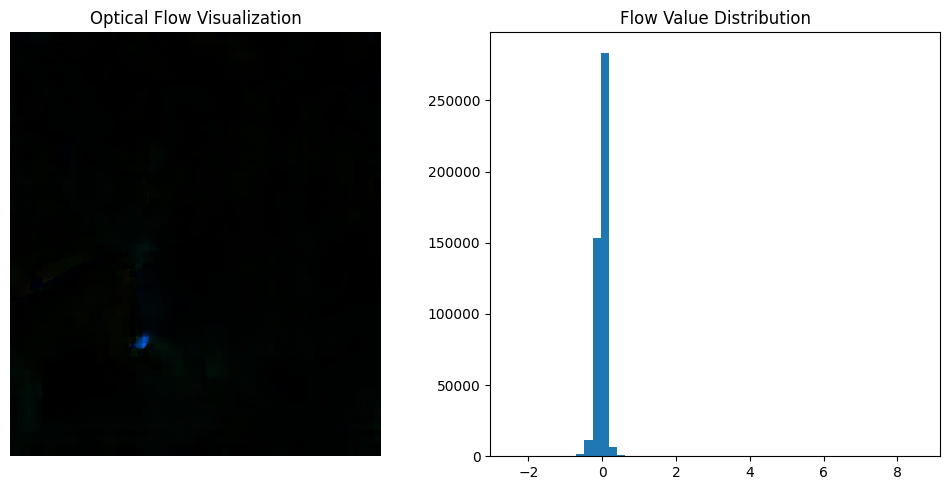

Optical flow visualization saved as 'optical_flow_result.png'.


In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tf_raft.model import RAFT

def flow_to_rgb(flow, max_flow=None):
    """Convert flow to RGB image for visualization."""
    h, w = flow.shape[:2]
    flow_map = np.zeros((h, w, 3), dtype=np.float32)
    
    # Compute the magnitude and angle of the flow
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    
    # Print flow statistics for debugging
    print("Flow magnitude stats - min: {:.4f}, max: {:.4f}, mean: {:.4f}".format(
        np.min(magnitude), np.max(magnitude), np.mean(magnitude)
    ))
    
    # Normalize the magnitude
    epsilon = 1e-5
    if max_flow is None:
        max_flow = max(np.max(magnitude), epsilon)
    magnitude = np.clip(magnitude / max_flow, 0, 1)
    
    # Angle is in radians, convert to degrees
    angle = angle * 180 / np.pi / 2
    
    # Build the HSV image
    flow_map[..., 0] = angle
    flow_map[..., 1] = 1
    flow_map[..., 2] = magnitude
    
    # Convert HSV to RGB
    flow_map = cv2.cvtColor(flow_map, cv2.COLOR_HSV2BGR)
    
    return flow_map

# Load and preprocess your images
def load_and_preprocess_image(path, target_size=(448, 512)):
    image = cv2.imread(path)
    image = cv2.resize(image, target_size)
    image = image.astype(np.float32)
    image = image[np.newaxis, ...]  # Add batch dimension
    return image

# Initialize the RAFT model and perform inference
def run_raft(image1_path, image2_path, checkpoint_path, iters=12, iters_pred=12):
    # Load the images
    x1 = load_and_preprocess_image(image1_path)
    x2 = load_and_preprocess_image(image2_path)

    # Initialize the RAFT model
    raft = RAFT(iters=iters, iters_pred=iters_pred)

    try:
        # Load the pre-trained weights without restoring the optimizer state
        raft.load_weights(checkpoint_path).expect_partial()
        print("Checkpoint loaded successfully.")
    except Exception as e:
        print("Error loading checkpoint:", e)
        return None, None

    # Perform inference
    try:
        flow_predictions = raft([x1, x2], training=False)
        # Get the final flow prediction
        flow = flow_predictions[-1].numpy().squeeze()
    except Exception as e:
        print("Error during inference:", e)
        return None, None

    # Convert flow to RGB for visualization
    flow_rgb = flow_to_rgb(flow)

    return flow_rgb, flow

# Paths to your images and checkpoint
image1_path = 'images/image1.png'
image2_path = 'images/image2.png'
checkpoint_path = 'checkpoints_flyingChairs/model'
# checkpoint_path = 'checkpoints_mpiSintel/model'

# Run RAFT and get the flow visualization
flow_rgb, flow = run_raft(image1_path, image2_path, checkpoint_path)

if flow_rgb is not None:
    # Display the result using Matplotlib
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(flow_rgb)
    plt.title('Optical Flow Visualization')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.hist(flow.flatten(), bins=50)
    plt.title('Flow Value Distribution')

    plt.tight_layout()
    plt.show()

    # Save the result
    # plt.imsave('sintel_results/optical_flow_result_mpiSintel_iter=30.png', flow_rgb)
    plt.imsave('flying_chair_results/optical_flow_result_flyingChair_iter=12.png', flow_rgb)
    print("Optical flow visualization saved as 'optical_flow_result.png'.")
else:
    print("Flow visualization could not be generated.")